In [1]:
using StatsBase
using LinearAlgebra
using JuMP
using Gurobi
using CSV
using Distances
using PyPlot
using SparseArrays
using Printf

In [2]:
struct Pile
    points::Matrix{Float64} # 2 x n matrix where each column is a point
    weights::Vector{Float64}
end
Base.length(p::Pile) = length(p.weights)

function Base.rand(::Type{Pile}; n_points = rand(1:5),
                                 points = rand(2,n_points),
                                use_rand = true)
    if use_rand
        
        weights = rand(n_points)
#         weights = weights/sum(weights)
    else
        weights = ones(n_points)
#         weights = weights/sum(weights)
    end
    return Pile(points, weights)
end


In [3]:
P_dat = CSV.read("../data/artificial/P.csv"; header=false)
P_points = convert(Matrix, P_dat)'


Q_dat = CSV.read("../data/artificial/Q.csv"; header=false)
Q_points = convert(Matrix, Q_dat)'

P = rand(Pile, n_points = size(P_points)[2], points = P_points,use_rand = false)
Q = rand(Pile, n_points = size(Q_points)[2], points = Q_points, use_rand = false)

cost = pairwise(Euclidean(), P.points, Q.points; dims=2)

7×25 Array{Float64,2}:
 1.80278  2.35432   2.88314   3.3434    …  0.901387  1.28862   1.80278
 1.41421  1.90939   2.41091   2.85666      0.901387  1.02839   1.41421
 1.11803  1.49958   1.95256   2.37545      1.14564   0.977055  1.11803
 1.0      1.16262   1.52069   1.90394      1.52069   1.16262   1.0    
 1.11803  0.977055  1.14564   1.45163      1.95256   1.49958   1.11803
 1.41421  1.02839   0.901387  1.04378   …  2.41091   1.90939   1.41421
 1.80278  1.28862   0.901387  0.756108     2.88314   2.35432   1.80278

In [30]:
solCount = 1000
m = JuMP.direct_model(Gurobi.Optimizer(PoolSearchMode=2, PoolSolutions=solCount, SolutionNumber=0))

@variable(m, X[axes(cost,1), axes(cost,2)] ≥ 0, Int)
@objective(m, Min, cost ⋅ X)
@constraint(m,sum(X) .== min(sum(P.weights), sum(Q.weights)))
@constraint(m, X * ones(Int, length(Q)) .<= P.weights)
@constraint(m, X'ones(Int, length(P)) .<= Q.weights);
optimize!(m)
obj = objective_value(m)
println(obj)
# solution = value.(X)

solution_pool = zeros(solCount, length(P),length(Q))
cnt = 0
for i in 0:(solCount-1)
    try
        setparam!(m.moi_backend.inner,"SolutionNumber", i)
        
        xn = Gurobi.get_dblattrarray(m.moi_backend.inner, "Xn", 1, length(X))
        xn_val = Gurobi.get_dblattr(m.moi_backend.inner, "PoolObjVal")
        if(round(xn_val,digits=10) != round(obj, digits=10))
            println(xn_val,' ', obj)
            break
        end
        default = zeros(length(P),length(Q))
        for i in 0:length(P)-1
            default[i+1,:] = xn[(i*length(Q))+1:(i+1)*length(Q)]
        end
        solution_pool[i+1,:,:] = default
        cnt+=1
    catch 
        break
    end
end
sol_pool = deepcopy(solution_pool[1:cnt,:,:]);

Optimize a model with 33 rows, 175 columns and 525 nonzeros
Variable types: 0 continuous, 175 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+00]
Presolve time: 0.00s
Presolved: 33 rows, 175 columns, 525 nonzeros
Variable types: 0 continuous, 175 integer (175 binary)

Root relaxation: objective 6.269101e+00, 10 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       6.2691008    6.26910  0.00%     -    0s
Optimal solution found at node 0 - now completing solution pool...
     0     0          -    0         6.26910    6.26910  0.00%     -    0s
     0     0          -    0         6.26910    6.26910  0.00%     -    0s
     0     2          -    0         6.26910    6.26910  0.00%     -    0s

Explored 23353 

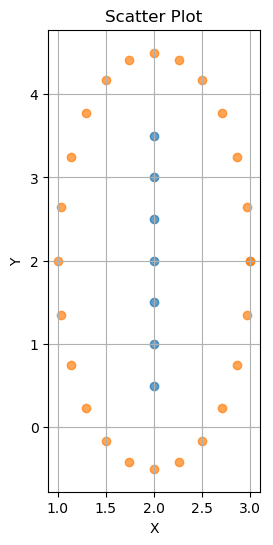

In [5]:
fig = figure("pyplot_scatterplot",figsize=(6,6))
ax = PyPlot.axes()
subplot(122)
# ax = fig[:add_subplot](1,2,2);
scatter(P.points[1,:],P.points[2,:],alpha=0.7)
scatter(Q.points[1,:],Q.points[2,:],alpha=0.7)

PyPlot.title("Scatter Plot")
xlabel("X")
ylabel("Y")
grid(true)
# gcf() # Needed for IJulia to plot inline

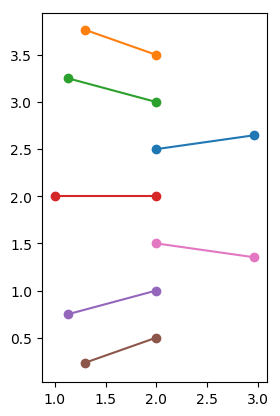

In [33]:
solOther = sparse(sol_pool[rand(1:cnt),:,:])
for (x,y,v) in zip(findnz(solOther)...)
    
    x_pos = [P.points[:,x][1], Q.points[:,y][1]]
    y_pos = [P.points[:,x][2], Q.points[:,y][2]]
    subplot(122)
    scatter(x_pos, y_pos)
    plot(x_pos, y_pos)
end